# CAP4453 Robot Vision: Softmax Classifier

This notebook provides a skeleton implementation of a one‑layer linear classifier using PyTorch. You will load the CIFAR‑10 or MNIST dataset, flatten the images, and train a linear classifier with softmax loss. The code below is only a starting point; feel free to modify it as needed. The model will automatically use a GPU if available.


In [10]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Choose device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Select dataset: 'cifar10' or 'mnist'
dataset_name = 'cifar10'

if dataset_name.lower() == 'cifar10':
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    num_classes = 10
    input_dim = 32*32*3
elif dataset_name.lower() == 'mnist':
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    num_classes = 10
    input_dim = 28*28
else:
    raise ValueError('Unknown dataset')

# Split train into train/val
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")


Using device: cpu


/Users/bjethwani/Downloads/Cifar-10_Recognition/.venv/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Train samples: 45000, Validation samples: 5000, Test samples: 10000


In [35]:
# Define a simple linear classifier using PyTorch
import torch.nn as nn

class LinearClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten
        return self.fc(x)
    

# Initialize model, loss function and optimizer
model = LinearClassifier(input_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-2
weight_decay = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Track loss through time for graph
losses = []

# Training loop skeleton
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss / total
    train_acc = 100. * correct / total

    # Evaluate on validation set
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    val_acc = 100. * val_correct / val_total
    print(f"Epoch {epoch+1}/{num_epochs}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.2f}%, Val acc: {val_acc:.2f}%")
    print(f"Regularization: {weight_decay}, Learning Rate: {learning_rate}")
    losses.append(train_loss)
            


Epoch 1/20, Train loss: 2.0049, Train acc: 28.88%, Val acc: 31.00%
Regularization: 0.0001, Learning Rate: 0.01
Epoch 2/20, Train loss: 1.8725, Train acc: 34.63%, Val acc: 34.64%
Regularization: 0.0001, Learning Rate: 0.01
Epoch 3/20, Train loss: 1.8336, Train acc: 36.28%, Val acc: 35.18%
Regularization: 0.0001, Learning Rate: 0.01
Epoch 4/20, Train loss: 1.8118, Train acc: 37.19%, Val acc: 34.18%
Regularization: 0.0001, Learning Rate: 0.01
Epoch 5/20, Train loss: 1.7973, Train acc: 37.78%, Val acc: 34.54%
Regularization: 0.0001, Learning Rate: 0.01
Epoch 6/20, Train loss: 1.7860, Train acc: 38.23%, Val acc: 35.60%
Regularization: 0.0001, Learning Rate: 0.01
Epoch 7/20, Train loss: 1.7762, Train acc: 38.44%, Val acc: 38.02%
Regularization: 0.0001, Learning Rate: 0.01
Epoch 8/20, Train loss: 1.7664, Train acc: 38.91%, Val acc: 37.26%
Regularization: 0.0001, Learning Rate: 0.01
Epoch 9/20, Train loss: 1.7637, Train acc: 39.02%, Val acc: 37.50%
Regularization: 0.0001, Learning Rate: 0.01
E

In [36]:
# Evaluate testing error with optimized hyper paramters:

model.eval()
correct = 0
total = 0

for images, labels in test_loader:
    images,labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc}")

Test Accuracy: 39.29


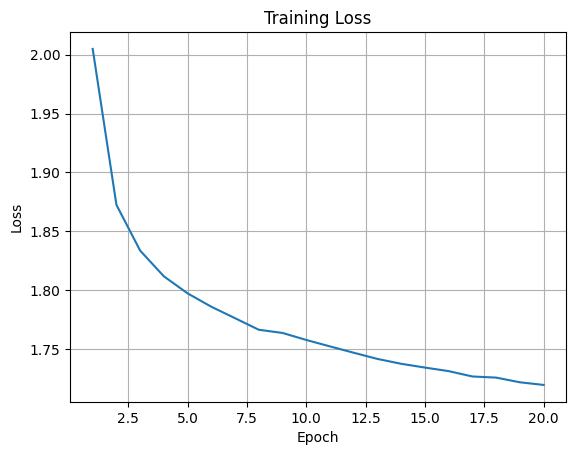

In [37]:
# Linear Classifier plot
plt.plot(range(1, num_epochs + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.savefig('loss_curve.pdf')
plt.show()



### Next steps

- Experiment with different learning rates, regularization strengths and batch sizes. Please record (e.g., screenshot, copy training/val log history etc) the validation set performances with different hyper‑parameters in the report. 
- After choosing hyper‑parameters, train on the combined train+validation set and report the test accuracy.
- Plot training and validation accuracies over epochs.
- Compare these results with those obtained using a two‑layer network (see the next notebook).
